<a href="https://colab.research.google.com/github/sr229/gacha-prng/blob/main/gacha_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Jupyter Notebook to Calculate Gacha Probabilities in Python

## What is this about?

This specific Notebook is used to calculate probabilities for Gacha games on N times of iterations. It was built to facilitate checking the probability of getting a ideal roll based on the number of iterations and attempts a user has made.

We look on two factors that affects how a roll's outcome:

- Time-based: some gacha games instead of using a fixed UID seed would use the server time as a seed. This allows it to be a bit more unpredictable however it still maintains it's usual predictability having a fixed rate and a relatively non-cryptographically secure PRNG.

- Fixed seed-based: this is the most usual implementations seen in gacha games. They either use the UID or a internal identifier of the user to get your roll. Since we're using a predictable non-secure PRNG, this is the most predictable kind of method usually used and employed by games. Probability is considered constant as well since the seed is never changing.

## The Algorithm

This gacha probability notebook uses the Subtractive Pseudo-Random Number Generator used by C#. 

Quoting [RosettaCode](https://rosettacode.org/wiki/Subtractive_generator):
> A subtractive generator calculates a sequence of random numbers, where each number is congruent to the subtraction of two previous numbers from the sequence.

The reason this was picked because a large majority of the games currently that has gacha elements are based on Unity C#, and we can assume some of them uses client-side PRNG (however most gacha games have server side PRNG).

## The code

In [ ]:
from random import random
from matplotlib import pyplot as plt
import time
import statistics
from numpy import sqrt,empty,array,average,set_printoptions
from numba import jit
import sys

set_printoptions(threshold=sys.maxsize)

In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [ ]:
import collections

""""
Implements the Subtractive PRNG used by C#: https://rosettacode.org/wiki/Subtractive_generator#C.2B.2B.
seed is used to define a new generation for the PRNG. A new call of the srand function is always either a new generation based on that seed alone.

:param seed: the seed used for generation. It has to be a value within 1-10^9. Keep in mind this parameter is not persisted between calls. One function call has its own instance. 
"""
def srand(seed):
    r = collections.deque(maxlen=55)
    s = collections.deque(maxlen=55)
    m = 10**9
    s.extend([seed, 1])
    s.extend((s[n-2] - s[n-1]) % m for n in range(2, 55))
    r.extend(s[(34 * (n+1)) % 55] for n in range(55))
    for _ in range(219-54):
        r.append((r[0] - r[31]) % m)
    while True:
        r.append((r[0] - r[31]) % m)
        yield r[54]

# Verify our SPRNG works
x = srand(1029202)
print(next(x))

521657541


In [ ]:
"""
Calculates the probability between N times of iterations.
:param seed: the seed used by the PRNG to calculate the rate of roll. This could be any positive integers from 1 to 10^9.
:param rate: the rate of the roll. By default it uses 0.02.
:param iterations: the N amount of iterations to perform to check for a probability
:param total_samples: the amount of total samples to check against.
"""
# We're using Numba to speed up our increments, since the LLVM opcodes is going to help us alot.
@jit(parallel=True, forceobj=True)
def get_probability(seed, rate, rate_increment, iterations, total_samples, debug=False):

    tl_mean_list = []

    prng = srand(seed)
    s = 0
    start = time.time()

    while s < iterations:
        trial_list = []
        a = 0

        while a < total_samples:
            trial = 1
            x = next(prng) / 10**9
            rate_current = rate
            while x > rate_current:
                trial += 1
                x = next(prng) / 10**9
                if trial > 50:
                    rate_current += rate_increment
                
            a += 1
            trial_list.append(trial)
        
        eee = sum(trial_list) / iterations
        tl_mean_list.append(eee)
        s += 1

        if s % 100 == 0 and debug is True:
            endf = time.time()
            print('progress =','%.2f' % (s*100/iterations),'% (time =','%.2f' % (endf-start),'s)')
  
    return tl_mean_list

### Probability calculation using a fixed seed

The following example plots the probability at 10000 iterations at a fixed rate of 0.02.

mean = 34.57004609
variance = 0.04479807826653855
sd = 0.2116555651678891


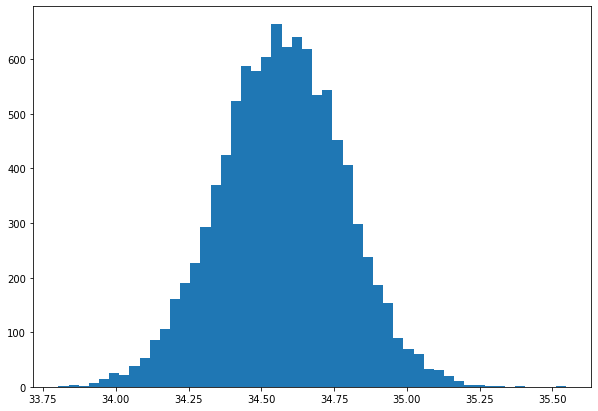

In [ ]:
# Number of iterations
N = 10000
# Sample Size
sN = 10000

# Execute. Keep in mind it may take a while for the function to complete since it's going through a large number of iterations.
tl_mean_list = get_probability(102927162, 0.02, 0.02, N, sN)

var = statistics.variance(tl_mean_list)

print('mean =',sum(tl_mean_list)/sN)
print('variance =',var)
print('sd =',sqrt(var))

fig, ax = plt.subplots(figsize = (10,7))
ax.hist(tl_mean_list, bins = 50)

plt.show()

### Probability calculation using the Unix time

The following example plots the probability at 10000 iterations at a fixed rate of 0.02 but using the ever changing [Unix time](https://en.wikipedia.org/wiki/Unix_time) as our seed.

mean = 34.58273061224491
variance = 0.00022249166622222223
sd = 0.01491615453869469


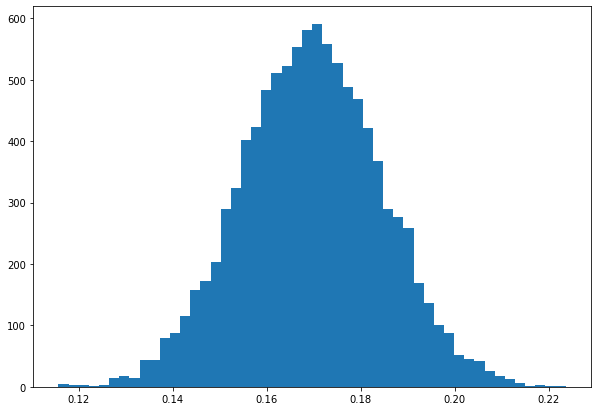

In [ ]:
# Number of iterations
N = 10000
# Sample Size
sN = 49

# Execute. Keep in mind it may take a while for the function to complete since it's going through a large number of iterations.
tl_mean_list = get_probability(int(time.time()), 0.02, 0.02, N, sN)

var = statistics.variance(tl_mean_list)

print('mean =',sum(tl_mean_list)/sN)
print('variance =',var)
print('sd =',sqrt(var))

fig, ax = plt.subplots(figsize = (10,7))
ax.hist(tl_mean_list, bins = 50)

plt.show()

## Credits

These works are created as a collaboration of the following people:

- [SurfChu85](https://twitter.com/SurfChu85)
- [Ayane Satomi](https://github.com/sr229)
- [Eyenine](https://twitter.com/Eyenine_i9)
- [KaidenFrizu](https://github.com/KaidenFrizu)